In [48]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_csv(r'C:\Users\ashbat\Desktop\totalByWeekWHApples.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'W-MON'

In [50]:
df.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,221.71780,0
2016-03-21,279.53034,16
2016-03-28,434.47406,0
2016-04-04,514.50168,0
2016-04-11,724.67906,0


In [51]:
print(df.index.freq)

<Week: weekday=0>


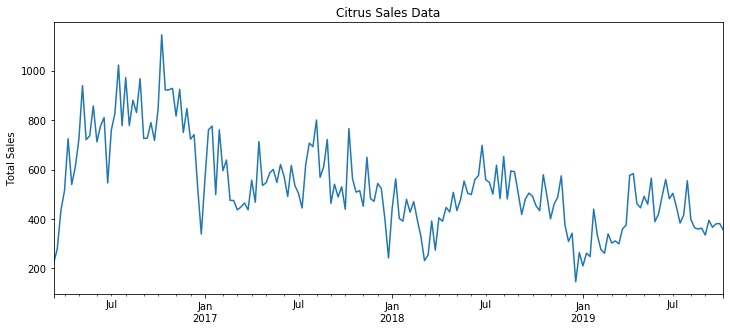

In [52]:
title='Citrus Sales Data'
ylabel='Total Sales'
xlabel='' 

ax = df['TOTAL_PRICESELL'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

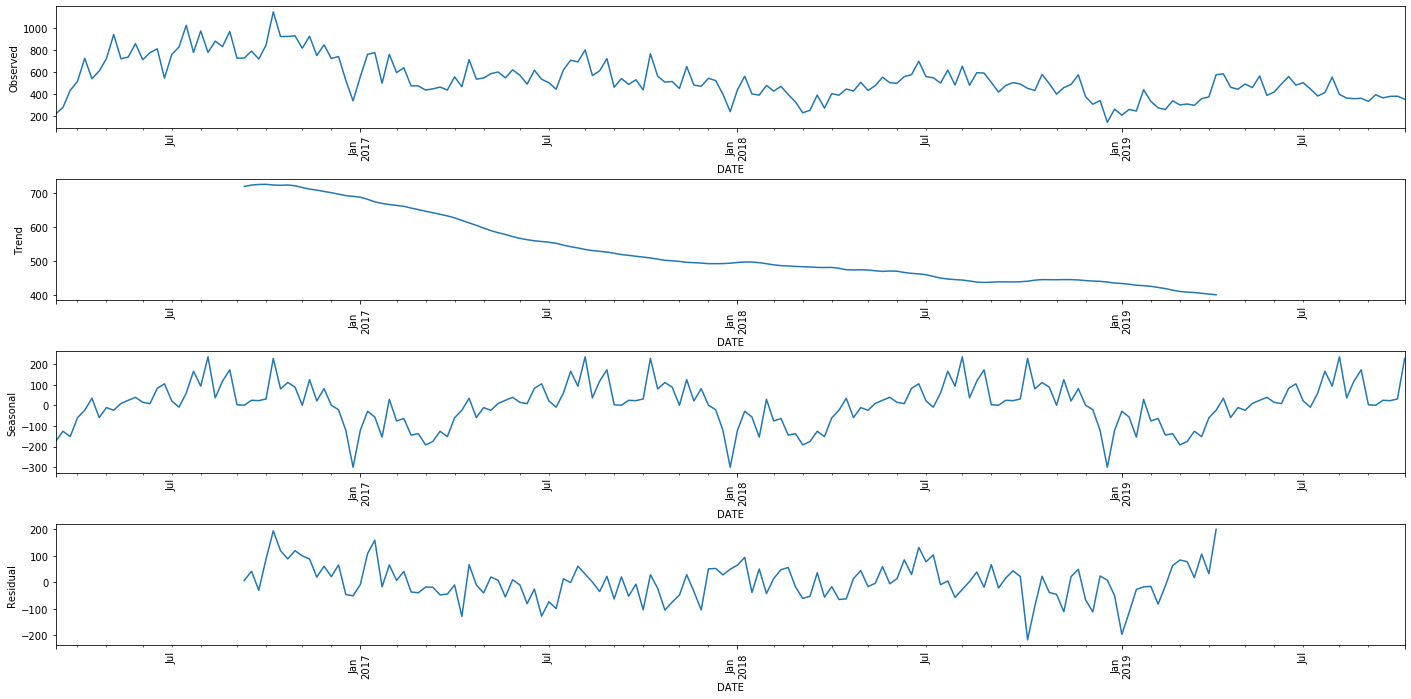

In [53]:
result = seasonal_decompose(df['TOTAL_PRICESELL'], model='add')

observed = result.observed
trend = result.trend
seasonal =  result.seasonal
residual =  result.resid

decomp_data = pd.DataFrame({"Observed":observed, "Trend": trend, "Seasonal":seasonal,"Residual":residual})

import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
figure.tight_layout(pad=3.0)
for i, ax in enumerate(axes):
    ax = decomp_data.iloc[:,i].plot(ax=ax)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(decomp_data.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

figure.savefig('apples_decomp.png')

In [54]:
#auto_arima(df['TOTAL_PRICESELL'],seasonal=True,m=52).summary()

In [55]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [56]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -817.710
Date:                            Sun, 17 May 2020   AIC                           1643.421
Time:                                    12:06:25   BIC                           1655.012
Sample:                                03-14-2016   HQIC                          1648.131
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5460      0.071     -7.741      0.000      -0.684      -0.408
ar.S.L52      -0.0464      0.396     -0.117      0.907      -0.822       0.729
ma.S.L52       0.5727      0.538      1.064      0.287      -0.482       1.627
sigma2      1.027e+04   2119.188      4.847      0.000    6117.854    1.44e+04
===================================================================================
Ljung-Box (Q):                       33.94   Jarque-Bera (JB):                 3.42
Prob(Q):                              0.74   Prob(JB):                         0.18
Heteroskedasticity (H):               0.26   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

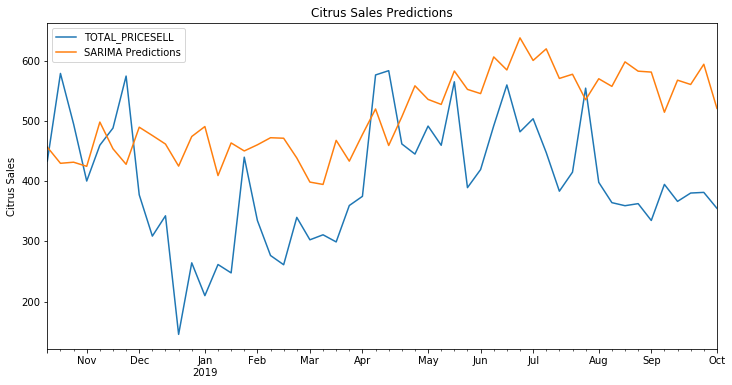

In [58]:
#Compare to validation data
title='Citrus Sales Predictions'
ylabel='Citrus Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [59]:
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMA MSE: {error1:11.10}')
print(f'SARIMA RMSE: {error2:11.10}')

SARIMA MSE: 22305.71846
SARIMA RMSE: 149.3509908


In [60]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Forecast')

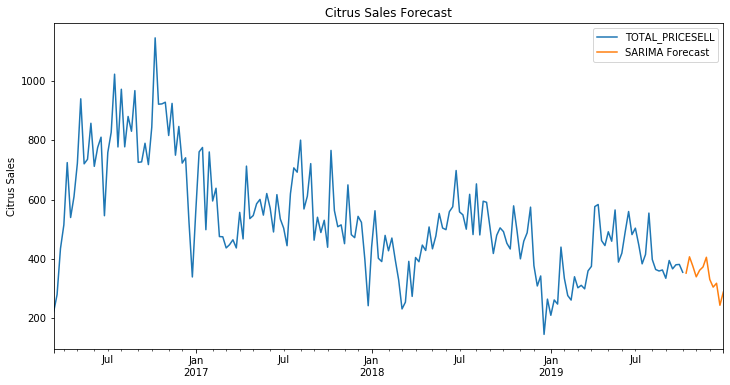

In [61]:
title='Citrus Sales Forecast'
ylabel='Citrus Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [62]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [63]:
train.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,221.71780,0
2016-03-21,279.53034,16
2016-03-28,434.47406,0
2016-04-04,514.50168,0
2016-04-11,724.67906,0


In [64]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],exog=train['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -809.576
Date:                            Sun, 17 May 2020   AIC                           1629.152
Time:                                    12:06:36   BIC                           1643.641
Sample:                                03-14-2016   HQIC                          1635.040
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
holidayWeekS    -6.1435      1.587     -3.871      0.000      -9.254      -3.033
ma.L1           -0.5184      0.080     -6.487      0.000      -0.675      -0.362
ar.S.L52        -0.1473      0.434     -0.339      0.734      -0.998       0.704
ma.S.L52         0.6956      0.697      0.999      0.318      -0.670       2.061
sigma2        8830.3083   2676.544      3.299      0.001    3584.379    1.41e+04
===================================================================================
Ljung-Box (Q):                       31.04   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.84   Prob(JB):                         0.14
Heteroskedasticity (H):               0.36   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holidayWeekS']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMAX MSE: {error1:11.10}')
print(f'SARIMAX RMSE: {error2:11.10}')

SARIMAX MSE: 27257.06243
SARIMAX RMSE: 165.0971303


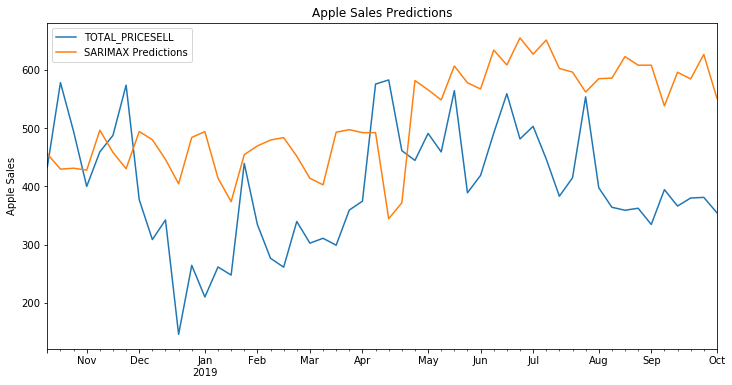

In [66]:
#Compare to validation data
title='Apple Sales Predictions'
ylabel='Apple Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [67]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],exog=df['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()

In [71]:
start=len(df)
end=len(df) + 11
exog_forecast = pd.read_csv(r'C:\Users\ashbat\Desktop\ExogHolidays.csv',index_col='DATE',parse_dates=True)
exog_forecast.index.freq = 'W-MON'
exog_forecast = exog_forecast[['holidayWeekS']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

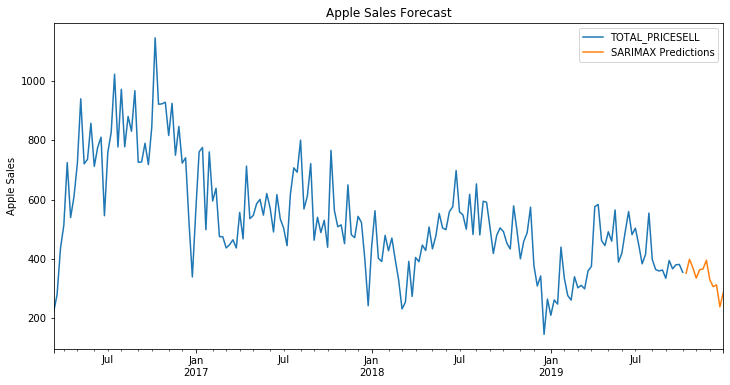

In [73]:
title='Apple Sales Forecast'
ylabel='Apple Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);